# Problem Statement:

>The data is available as two attached CSV files:
>
> *takehome_user_engagement.csv*
> 
> *takehome_users.csv* 
>
>The data has the following two tables:
>
> 1) A user table ("*takehome_users*") with data on 12,000 users who signed up for the product in the last two years. This table includes:
>
> * name: the user's name 
> * object_id: the user's id 
> *email: email address 
> *creation_source: how their account was created. This takes on one of 5 values:
>   - PERSONAL_PROJECTS: invited to join another user's personal workspace 
>   - GUEST_INVITE: invited to an organization as a guest (limited permissions) 
>   - ORG_INVITE: invited to an organization (as a full member) 
>   - SIGNUP: signed up via the website 
>   - SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id) 
>
> * creation_time: when they created their account 
> * last_session_creation_time: unix timestamp of last login
> * opted_in_to_mailing_list: whether they have opted into receiving marketing emails
> * enabled_for_marketing_drip: whether they are on the regular marketing email drip 
> * org_id: the organization (group of users) they belong to
> * invited_by_user_id: which user invited them to join (if applicable).
>
> 2) A usage summary table ( "*takehome_user_engagement*" ) that has a row for each day 
that a user logged into the product. 
>
>Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period , identify which factors predict future user adoption . 
>
> We suggest spending 1-­2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

***********************************************************************************************************

# Solution:

In [10]:
%reset -f

Import Necessary Libraries:

In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

### Data Wrangling:

Import Datasets:

In [12]:
engage = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [13]:
daydf = engage.copy()

In [14]:
daydf['day'] = daydf.time_stamp.dt.dayofweek

In [15]:
daydf.head()

,time_stamp,user_id,visited,day
0,2014-04-22 03:53:30,1,1,1
1,2013-11-15 03:45:04,2,1,4
2,2013-11-29 03:45:04,2,1,4
3,2013-12-09 03:45:04,2,1,0
4,2013-12-25 03:45:04,2,1,2


In [16]:
daydfsum = daydf.groupby(['user_id','day']).sum().reset_index()

In [17]:
daydfsum.head()

,user_id,day,visited
0,1,1,1
1,2,0,3
2,2,1,1
3,2,2,2
4,2,3,2


In [18]:
daydfsum[daydfsum.duplicated(subset=None, keep=False)]

,user_id,day,visited


There exists no same rows in the dataset, so every datapoint is different. This implies that the logins are different for every day in the week.

We will calculate the login timestamps based on weekly (7 days) counts. Those who have logged in more than 3 separate days in 7 days will be considered as adopted user.

In [19]:
engage['week'] = engage.time_stamp.dt.isocalendar().week.astype(str)
#engage['user_id']= engage['user_id'].astype(str)

In [20]:
engage.head()

,time_stamp,user_id,visited,week
0,2014-04-22 03:53:30,1,1,17
1,2013-11-15 03:45:04,2,1,46
2,2013-11-29 03:45:04,2,1,48
3,2013-12-09 03:45:04,2,1,50
4,2013-12-25 03:45:04,2,1,52


In [21]:
engage[engage.duplicated(subset=None, keep=False)]

,time_stamp,user_id,visited,week


So, every row is unique.

In [22]:
# Group by the dataset by user_id and week and calculate the login counts.
df1 = engage.groupby(['user_id','week']).sum().reset_index()

In [23]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57172 entries, 0 to 57171
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  57172 non-null  int64 
 1   week     57172 non-null  object
 2   visited  57172 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ MB


In [24]:
df1.head(50)

,user_id,week,visited
0,1,17,1
1,2,1,1
2,2,10,1
3,2,11,1
4,2,14,1
5,2,2,1
6,2,46,1
7,2,48,1
8,2,50,1
9,2,52,1


In [25]:
# Define adopted user:

df1['adopted_user']= np.where(df1['visited'] >= 3 , 1 ,0)
df1.reset_index(drop=True, inplace=True)

In [26]:
df1.head(50)

,user_id,week,visited,adopted_user
0,1,17,1,0
1,2,1,1,0
2,2,10,1,0
3,2,11,1,0
4,2,14,1,0
5,2,2,1,0
6,2,46,1,0
7,2,48,1,0
8,2,50,1,0
9,2,52,1,0


In [27]:
df1['user_id'].nunique()

8823

We have 8823 users. Now lets analyze the other dataset.

In [28]:
user = pd.read_csv('takehome_users.csv', encoding='cp1252')
user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [29]:
user.shape

(12000, 10)

Check Missing Values:

In [30]:
missing = pd.concat([user.isnull().sum(), 100 * user.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count',ascending=False)

,count,%
invited_by_user_id,5583,46.525
last_session_creation_time,3177,26.475
object_id,0,0.000
creation_time,0,0.000
name,0,0.000
email,0,0.000
creation_source,0,0.000
opted_in_to_mailing_list,0,0.000
enabled_for_marketing_drip,0,0.000
org_id,0,0.000


In [31]:
user[user['last_session_creation_time'].isnull()]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN
11,12,2014-04-17 23:48:38,Mathiesen Lærke,LaerkeLMathiesen@cuvox.de,ORG_INVITE,NaN,0,0,130,9270.0
14,15,2013-07-16 21:33:54,Theiss Ralf,RalfTheiss@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,175,NaN
15,16,2013-02-11 10:09:50,Engel René,ReneEngel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,211,NaN
...,...,...,...,...,...,...,...,...,...,...
11975,11976,2013-12-25 22:01:41,Kohl Leah,LeahKohl@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,248,NaN
11977,11978,2014-04-23 16:28:06,Castro Pedro,PedroCunhaCastro@gustr.com,PERSONAL_PROJECTS,NaN,1,0,29,NaN
11984,11985,2013-07-08 17:23:26,Jespersen Marcus,MarcusTJespersen@cuvox.de,PERSONAL_PROJECTS,NaN,0,0,74,NaN
11992,11993,2013-03-28 23:24:21,Townsend Isabel,IsabelTownsend@cuvox.de,PERSONAL_PROJECTS,NaN,0,0,281,NaN


There are 3177 rows that have missing last login timestamp. We will be unable to do any further analysis if this data is missing. It is hard to make any interpolation from the available dataset. So, we will delete these rows.

In [60]:
# Convert the datatype to datetime:
user['last_session_creation_time'] = pd.to_datetime(user['last_session_creation_time'],unit='s')

In [61]:
# Drop the rows with Nans:
user.dropna(subset = ['last_session_creation_time'], inplace=True)

Join the Datasets:

In [62]:
# Change the column name:
user.rename(columns = {'object_id' : 'user_id'}, inplace = True)
user.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,week
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,17
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,14
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,12
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,21
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,4


In [63]:
# Create a week column to from the last login timestamp:
user['week'] = user.last_session_creation_time.dt.isocalendar().week.astype(str)
user.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,week
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,17
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,14
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,12
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,21
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,4


In [64]:
# Merge the two Datasets:
df = pd.merge(user,df1, on = ['user_id','week'], how = 'left')

#df = pd.merge(user,engage, on = ['user_id'], how = 'left')

In [37]:
df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,week,visited,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,17,1,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,14,1,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,12,1,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,21,1,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,4,1,0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     8823 non-null   int64         
 1   creation_time               8823 non-null   object        
 2   name                        8823 non-null   object        
 3   email                       8823 non-null   object        
 4   creation_source             8823 non-null   object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    8823 non-null   int64         
 7   enabled_for_marketing_drip  8823 non-null   int64         
 8   org_id                      8823 non-null   int64         
 9   invited_by_user_id          4776 non-null   float64       
 10  week                        8823 non-null   object        
 11  visited                     8823 non-null   int64       

We see that those who were not invited by any other user contains a Nan value. Since there exists no User id with '0', we will replace the Nans with 0.

In [65]:
# Replace the Nans in Column 'invited_by_user_id' with 0:
df['invited_by_user_id'] = df['invited_by_user_id'].fillna(0)

Redefine Datatypes:

In [40]:
df['user_id'] = df['user_id'].astype('str')
df['creation_time'] = df['creation_time'].astype('datetime64[ns]')
df['invited_by_user_id'] = df['invited_by_user_id'].astype('Int64')
df['visited'] = df['visited'].astype('Int64')
df['adopted_user'] = df['adopted_user'].astype('Int64')
df['org_id'] = df['org_id'].astype('str')
df['invited_by_user_id'] = df['invited_by_user_id'].astype('str')

To check if the duration of usage has any impact on adoptation, we will create a new column named 'duration_of_usage' calculated as the difference between account creation timestamp and last login timestamp.

In [41]:
df['duration_of_usage'] = df['last_session_creation_time'] - df['creation_time']
df['duration_of_usage'] = df['duration_of_usage'].dt.days

We got our final dataframe.

In [42]:
df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,week,visited,adopted_user,duration_of_usage
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,17,1,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,14,1,0,136
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,12,1,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,21,1,0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,4,1,0,5


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     8823 non-null   object        
 1   creation_time               8823 non-null   datetime64[ns]
 2   name                        8823 non-null   object        
 3   email                       8823 non-null   object        
 4   creation_source             8823 non-null   object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    8823 non-null   int64         
 7   enabled_for_marketing_drip  8823 non-null   int64         
 8   org_id                      8823 non-null   object        
 9   invited_by_user_id          8823 non-null   object        
 10  week                        8823 non-null   object        
 11  visited                     8823 non-null   Int64       

In [44]:
df.isnull().sum()

user_id                       0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
week                          0
visited                       0
adopted_user                  0
duration_of_usage             0
dtype: int64

In [45]:
df2= df.copy()

Drop unnecessary columns:

In [46]:
df2.drop(['user_id', 'creation_time','name','email','last_session_creation_time','week','visited'], axis=1, inplace=True)

In [47]:
df2.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,duration_of_usage
0,GUEST_INVITE,1,0,11,10803,0,0
1,ORG_INVITE,0,0,1,316,0,136
2,ORG_INVITE,0,0,94,1525,0,0
3,GUEST_INVITE,0,0,1,5151,0,1
4,GUEST_INVITE,0,0,193,5240,0,5


Hot Encoding 'creation_source' column:

In [48]:
df2 = pd.get_dummies(df2, columns=['creation_source'])

In [49]:
df2.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,duration_of_usage,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,10803,0,0,1,0,0,0,0
1,0,0,1,316,0,136,0,1,0,0,0
2,0,0,94,1525,0,0,0,1,0,0,0
3,0,0,1,5151,0,1,1,0,0,0,0
4,0,0,193,5240,0,5,1,0,0,0,0


First we will check if invited by other id or organization has any impact on adopting a user. So, for now we delete these two columns that has details. If found as important feature, we will look into further investigation.

In [50]:
df2.drop(['invited_by_user_id','org_id'], axis=1, inplace=True)

Check Correlation:

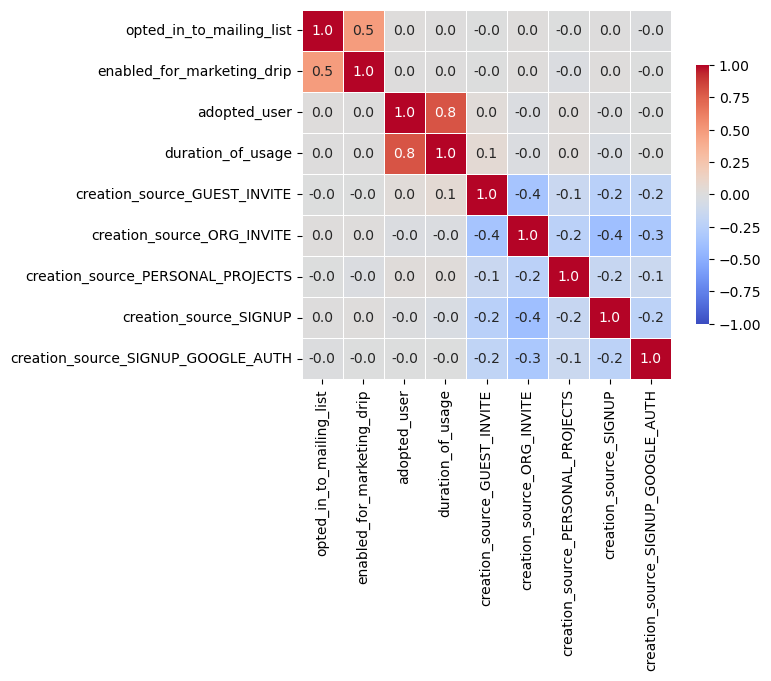

In [51]:
sns.heatmap(df2.corr(), cmap='coolwarm', vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7},
            annot=True,
            fmt=".1f"
           );
plt.show()

We see that duration of usage has a positive strong correlation with adoptation.

### Modelling:

Train and test split:

In [52]:
# Final Selection of columns for X and y:

X = df2.drop(['adopted_user'], axis=1)
y = df2['adopted_user']
y= y.astype('int')

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100,stratify=y)

In [54]:
X_train.shape, X_test.shape

((6617, 8), (2206, 8))

In [55]:
y_train.shape, y_test.shape

((6617,), (2206,))

Fit Classifiers:

This is a Classification problem, so we will consider Logistic, kNN, Random Forest, Decision Tree and SVC classifiers to find and fit the best model.

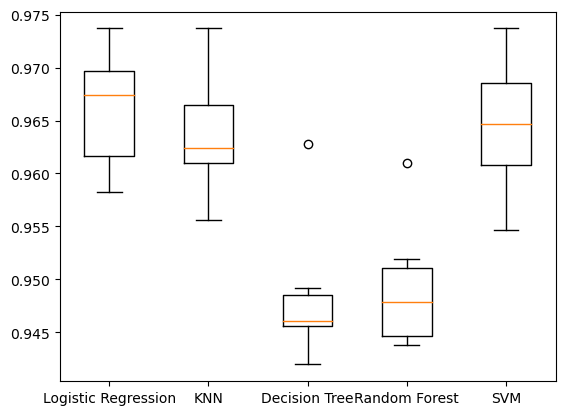

In [56]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

models = {"Logistic Regression": LogisticRegression(solver = 'newton-cg', max_iter = 500, C = 1000),
          "KNN": KNeighborsClassifier(),
          "Decision Tree": DecisionTreeClassifier(),
          "Random Forest": RandomForestClassifier(),
          "SVM": SVC(gamma='auto')
          }

results = []

for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kf)
    results.append(cv_results)


plt.boxplot(results, labels= models.keys())
plt.show()

From the graph above, we see that Logistic Regression performs as the best classifier for this dataset.

#### Performance Metrics:

In [57]:
from sklearn.metrics import classification_report, confusion_matrix

for name, model in models.items():
    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)
    prediction = model.predict(X_test)
    report = classification_report(prediction, y_test)
    mat = confusion_matrix(prediction, y_test)
    print("{} Test Set Accuracy: {}".format(name, test_score))
    print("{} Confusion Matrix:\n{}".format(name, mat))
    print("{} Classification Report:\n{}".format(name, report))

Logistic Regression Test Set Accuracy: 0.9632819582955575
Logistic Regression Confusion Matrix:
[[2002   58]
 [  23  123]]
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2060
           1       0.68      0.84      0.75       146

    accuracy                           0.96      2206
   macro avg       0.83      0.91      0.87      2206
weighted avg       0.97      0.96      0.97      2206

KNN Test Set Accuracy: 0.9592021758839528
KNN Confusion Matrix:
[[1997   62]
 [  28  119]]
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2059
           1       0.66      0.81      0.73       147

    accuracy                           0.96      2206
   macro avg       0.82      0.89      0.85      2206
weighted avg       0.96      0.96      0.96      2206

Decision Tree Test Set Accuracy: 0.9478694469628286
Decision T

From the Performance Metrics parameters, we observe that all the classifiers are more than 95% accurate in predicting adopted user. The best performer is the logistic regression and kNN Classifiers.

It is the call for the business decision to consider the Precision/ Recall matrices i.e. to prioritize the users who are assumed to be adopted will not be in future, or those who are adopted will not remain with the service in future.

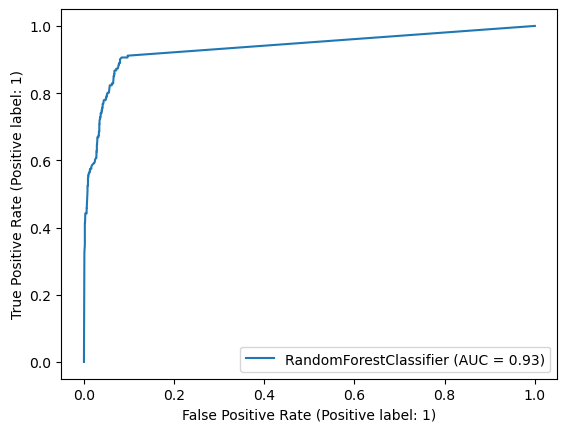

In [58]:
from sklearn.metrics import RocCurveDisplay

rf=RandomForestClassifier()
rf.fit(X_train, y_train)

RocCurveDisplay.from_estimator(rf, X_test, y_test)

#### Important Features:

Text(0.5, 1.0, 'Important Features')

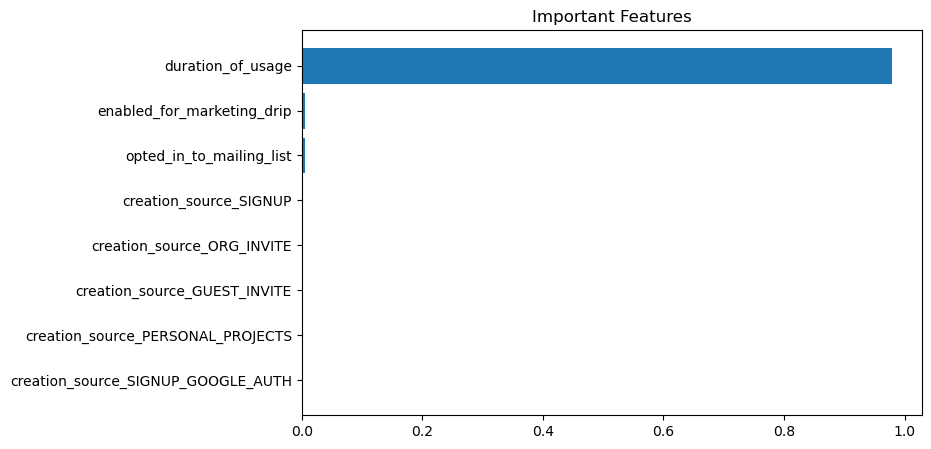

In [59]:
feature_importance = rf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(8, 5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Important Features')

From the chart, we observe that the duration of the usage highly impacts the adoptation among the users.

# Conclusion:

From the analysis, we find that Duration of using the product heavily impacts the retention of the adopted users. Also, none of the creation sources impact significantly on adaptation. So, the business plan should involve more on offering ways/ products to increase the **duration of the usage** of the product to create and retain the adopted users.

***********************************************************************************************************